In [16]:
import pandas as pd

par_par   = ['PAR', 'EHD', 'WAARDE']
point_par = ['LOC', 'PLT:X', 'PLT:Y', 'DATUM:TIJD']

df = pd.read_csv("../data/intermediate/rest.csv", parse_dates=['DATUM:TIJD'],
                       usecols=par_par + point_par + ['CPM'], engine='c')

df.rename({'DATUM:TIJD':'TIME'}, axis=1, inplace=True)

unit_of = {par:cdf.EHD.unique() for par,cdf in df.groupby('PAR')}

In [32]:
interests = ['ZS', 'GR', 'POC', 'TOC', 'O2', 'NO2', 'NO3', 'NH4', 'SALNTT']

# Wow i really should have learned this properly earlier.
idf = df[df.PAR.isin(interests)].pivot_table(columns='PAR', index=['LOC', 'TIME'], values='WAARDE') \
    .reset_index()

In [228]:
math.floor(0.3-1)

-1

In [298]:
import math

def figure_ticks(f, t, factors=[2,3,5,7]):
    x = 10**math.floor(f-1)
    while x < 10**f:
        for fa in factors:
            if x*fa > 10**f: yield x*fa
        x *= 10
    while x < 10**t:
        yield x
        for fa in factors:
            if x*fa < 10**t: yield x*fa
        x *= 10

import matplotlib.pyplot as plt
import numpy as np

def vergelijk_locaties(locs, substs=['ZS', 'NH4','NO2', 'NO3'], figsize=(15,6), df=idf, omit=None):
    fig,ax = plt.subplots(len(substs), figsize=figsize, squeeze=False)

    substs = [k if type(k) is tuple else (k, None) for k in  substs]

    any_of = set()
    ax[0][0].set_title("{}, allen mg/L{}".format(", ".join(locs),
                                              (" "*5+"Omits: " + ", ".join(e[0] for e in omit)) if omit else ""))

    for n,(k,ylim) in enumerate(substs):
        for loc in locs:
            cdf = df[(df.LOC==loc) & (~df[k].isna())]
            if len(cdf) > 0:
                any_of.add((k,ylim))  # Kindah sucks..
                cdf.plot('TIME', k, ax=ax[n][0], ylim=ylim,
                         label=loc, marker='.', legend=(n==0))
        ax[n][0].set_ylabel(k)

    left = [k for k in substs if (k in any_of)]
    if len(left) < len(substs) and len(left)>0:
        fig.clear()
        return vergelijk_locaties(locs, left, figsize=figsize, df=df,
                                  omit=[k for k in substs if (k not in any_of)])
    else:
        plt.subplots_adjust(hspace=0)  # But i do want the little markers..
        return fig,ax

import datetime
year_seconds = 365.25*24*3600

def year_continuous(t, t_of=False):  # time in years.
    year = t.year
    return (0 if t_of else year) + (t.timestamp() - datetime.datetime(year,1,1).timestamp())/year_seconds

val_av_yc = {}  # Collects -basically- the white lines.

def histogram_yearly(val, locs=None, df=idf, figsize=(15,6), timefun=year_continuous, bins=30):
    locs = locs or df.LOC.unique()
    df = df[df.LOC.isin(locs) & (~df[val].isna()) & (df[val]>0)]

    fig,ax = plt.subplots(figsize=(15,6))
    ax.set_ylabel("log10 {}, ({})".format(val, ",".join(unit_of[val])))
    ax.set_xlabel("maand")
    hd = ax.hist2d(df.TIME.apply(lambda t: 12*year_continuous(t,True)), np.log10(df[val]), bins=bins)
    fx,tx, fy,ty= hd[3].get_extent()

    tickvals = list(figure_ticks(fy, ty))
    ax.set_yticks(np.log10(tickvals))
    ax.set_yticklabels(tickvals)

    av_of_t = [fy+(ty-fy)*sum(n*i for i,n in enumerate(col))/sum(col)/len(col) for col in hd[0]]
    #val_av_yc[tuple(tuple(locs), val)] = av_of_t
    ax.plot([fx+(tx-fx)*(i+0.5)/len(hd[0]) for i in range(len(hd[0]))],
            av_of_t, color='white')

    for i in range(len(hd[0])):
        x = fx+(tx-fx)*(i+0.5)/len(hd[0])
        col = hd[0][i]
        ax.text(x, 0.95*fy + 0.05*ty,
                str(sum(int(n) for n in col)), color='white')
    return fig, ax

(<Figure size 1080x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f1174b527f0>)

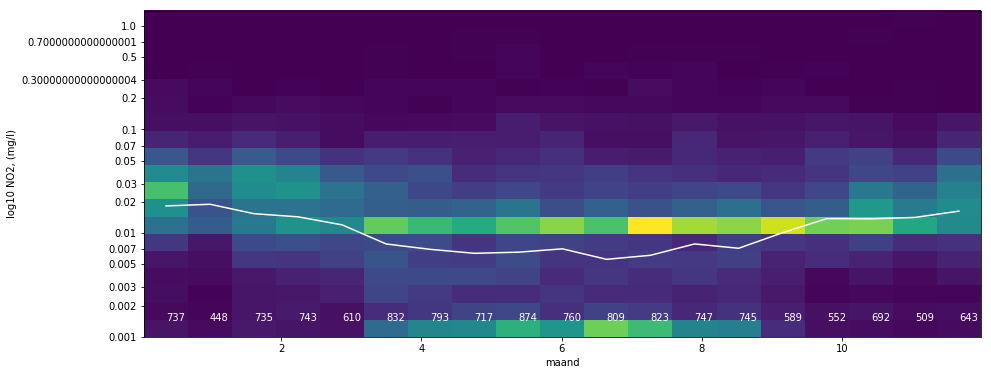

In [293]:
histogram_yearly('NO2', bins=19)

(<Figure size 1080x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f116ef2ac88>)

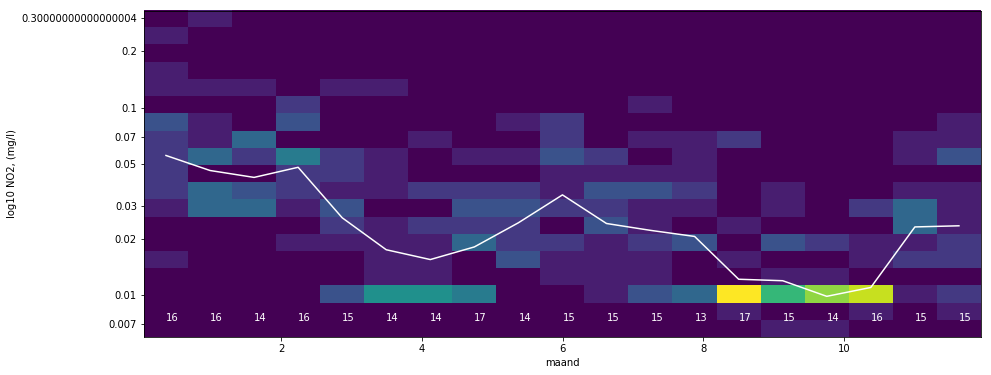

In [292]:
histogram_yearly('NO2', ['SCHAARVODDL'], bins=19)

<Figure size 1080x432 with 0 Axes>

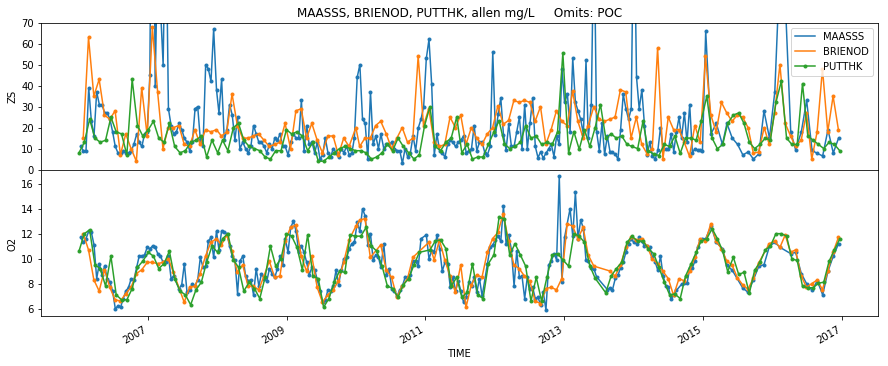

In [277]:
fig = vergelijk_locaties(['MAASSS', 'BRIENOD', 'PUTTHK'],
                   [('ZS', (0,70)), ('POC', (0,10)), 'O2'])

In [300]:
%%capture
# No output from this one.

import os

plot_all_dir = "img/plot_all/"

try:
    os.mkdir(plot_all_dir)
except BaseException as e:
    pass

for loc in df.LOC.unique():
    fig,ax = vergelijk_locaties([loc], [('ZS', (0,70)), ('POC', (0,10)), 'O2'], figsize=(8,7))
    fig.savefig(plot_all_dir + "over_tijd_" + loc + ".png",
                bbox_inches='tight', pad_inches=0)
    fig.clear()

    for par in ['POC', 'O2', 'ZS']:
        fig, ax = histogram_yearly(par, [loc], bins=20, figsize=(8,7))
        fig.savefig(plot_all_dir + "jaar_hist_" + loc + "_" + par + ".png",
                   bbox_inches='tight', pad_inches=0)
        fig.clear()

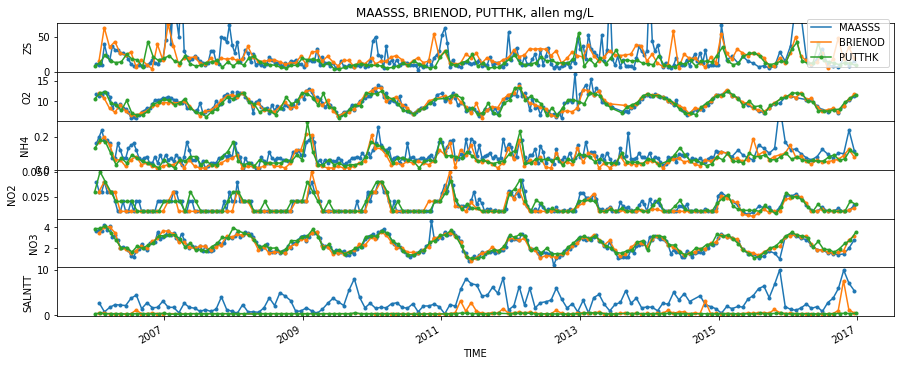

In [280]:
vergelijk_locaties(['MAASSS', 'BRIENOD', 'PUTTHK'],
                   [('ZS', (0,70)), 'O2', ('NH4', (0,0.3)),'NO2', 'NO3', 'SALNTT'])
None

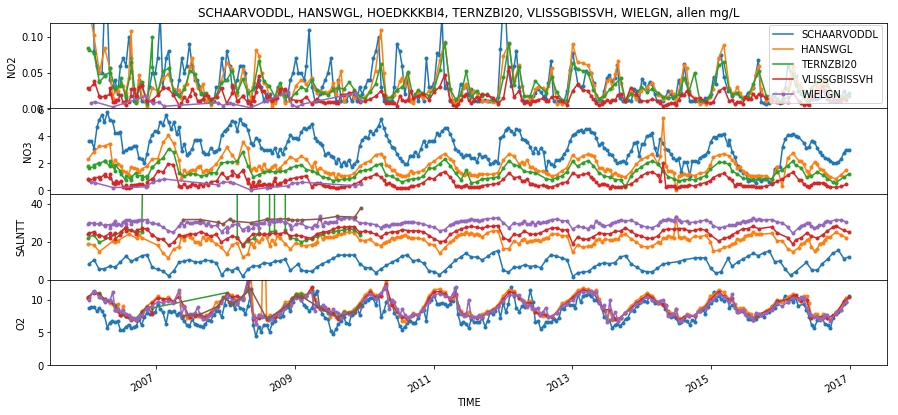

In [281]:
fig,ax = vergelijk_locaties(['SCHAARVODDL'] + ['HANSWGL', 'HOEDKKKBI4', 'TERNZBI20', 'VLISSGBISSVH',
                                      'WIELGN'],
                            [('NO2', (0,0.12)), 'NO3', ('SALNTT', (0,45)), ('O2', (0,13))], figsize=(15,7))